In [1]:
using ComputationalHeatTransfer

In [2]:
# using Plots
using LaTeXStrings

In [3]:
using Revise
using LinearAlgebra
using DifferentialEquations
using Interpolations
# using JLD
using Plots
pyplot()  

Plots.PyPlotBackend()

In [4]:
using JLD2

In [5]:
cd(dirname(pwd()))
cd("src") 

includet("OneDOHP.jl")
using ..OneDOHP

# OHP inner part

In [265]:
T0 = 273.15

273.15

In [266]:
nondi_Q_to_Q = 8.52e01
t_to_nondi_t = 3.42e-01
function di_T_to_nondi_T(di_T;T0=273.15) 
    
    (di_T+T0)/T0
    
end



di_T_to_nondi_T (generic function with 1 method)

In [282]:
    ω = sqrt(1.68e003);
    ℘L = 6.2e004;
    k = 115e-003

    θinitial=1.0
    θc = 1.0; # useless

    Hwc = 0.0; #not useful later on. H between wall and condenser, 
    Hₗ   =  1600.0; # liquid wall heat transfer coeffcient
#     Hₗ   =  2.57e004; # liquid wall heat transfer coeffcient
    Hδ  = 7.34e002;


In [283]:
    
    d = 6.56e-3 # dimensionless diameter
    L = 35.0  # total length of the pipe when streched to a 1D pipe
    L2D = 1.0 # the actual length of the bended pipe in the real world
    angle = 0*pi/2 # inclination angle 
    closedornot = true

true

In [328]:
#     nucleatenum = 1
#     Xstations = sort(rand(nucleatenum).*L);
Xstations = [L/2]
#     boilingΔt = 0.05

1-element Array{Float64,1}:
 17.5

In [329]:
tube = Tube(d,L,L2D,angle,closedornot);

In [330]:
Xe = map(tuple, [1.0], [3.0])
We = [0.0]
evap = Evaporator(Xe,We);

In [331]:
Xc = map(tuple, [0.0,3.0], [1.0,4.0])
cond = Condenser(θc,Xc,Hwc);

In [332]:
# numofX=1
# Xps = sort(rand(2*numofX).*L);
# Xp1s = Xps[1:2:end];
# Xp2s = Xps[2:2:end];

# dXdt0 = map(tuple,0*Xp1s,0*Xp2s)
# X0 = map(tuple,Xp1s,Xp2s);


In [333]:
N=numpts(ohp)
X0 = [(L/4, L*3/4)]
dXdt0 = [(0.0,0.0)]
ρ = 214.6
Xarrays,θarrays = constructXarrays(X0,N,θinitial,L)
liquids=Liquid(Hₗ,ρ,ω,℘L,X0,dXdt0,Xarrays,θarrays);

In [334]:
# P = [1.0,1.0,1.0,1.0,1.0]; # closed end

γ = 1.4;
Hδ = 7.34e2
P = 0*Xp1s .+ 1.0;
δ = 0*Xp1s .+ 2.86e-02;
vapors=Vapor(γ,Hδ,P,δ);

In [335]:
α = 0 # nondimensional thermal diffusivity = (αₐ d^2) / (νₗ height^2)
Xwallarray,θwallarray = constructXarrays(L,N,θinitial)
θwallarray = di_T_to_nondi_T(temperature_linesource(integrator)) .+ 0.02;

wall = Wall(α,Δt,Xstations,Xwallarray,θwallarray);

In [336]:
sys0_nomapping = PHPSystem_nomapping(tube,evap,cond,liquids,vapors,wall);
θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall = sys_interpolation(sys0_nomapping)
mapping = Mapping(θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall);

In [337]:
sys0 = PHPSystem(tube,evap,cond,liquids,vapors,wall,mapping);

### construct state vector U

In [391]:
Lvaporplug = XptoLvaporplug(X0,sys0.tube.L,sys0.tube.closedornot)
M = nondi_PtoD(P) .* Lvaporplug
# M = P.^(1/γ).* Lvaporplug


u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];

In [392]:
# cb_boiling =  DiscreteCallback(boiling_condition,boiling_affect!)
cb_boiling =  PeriodicCallback(boiling_affect!,0.01)
cb_merging =  DiscreteCallback(merging_condition,merging_affect!)

cbst = CallbackSet(cb_boiling,cb_merging);

### solve OHP (with nondimentional wall tempeature = 1.0)

In [393]:
tstep=1e-4
# tstep=5e-5*t_to_nondi_t

p = sys0
tspan = (0.0, 0.05);
prob = ODEProblem(ODE_innertube, u, tspan, p)

integrator_tube = init(deepcopy(prob), SSPRK22(), dt=tstep, callback=cbst);

@time solve!(integrator_tube);


Boiled!0.01
merged!
Boiled!0.04
  1.718696 seconds (984.05 k allocations: 1.255 GiB, 18.26% gc time)


In [394]:
p = deepcopy(getcurrentsys(integrator_tube.sol[end],sys0));
p.liquid.Xp;

In [395]:
sol = integrator_tube.sol
sysfinal = getcurrentsys.(sol.u,[sys0]);

In [396]:
sysfinal[152].liquid.Xp

2-element Array{Tuple{Float64,Float64},1}:
 (8.709321223523911, 17.478249702559452)
 (17.48367369349262, 26.214745214457075)

## the new vapor is saturated 

In [404]:
# boiling location liquid temperature (assume it is saturated)
sysfinal[102].mapping.θ_interp_liquidtowall(L/2)

1.0028432497209592

In [406]:
sysfinal[102].vapor.P[2]

1.0297398131083786

In [407]:
nondi_TtoP(sysfinal[102].mapping.θ_interp_liquidtowall(L/2))

1.0297398131083786

# plot the OHP

┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `fillcolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning:

┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `fillcolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning:

┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `fillcolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning:

┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `fillcolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning:

┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `fillcolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning:

┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `fillcolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning:

┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `fillcolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning:

┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `fillcolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning:

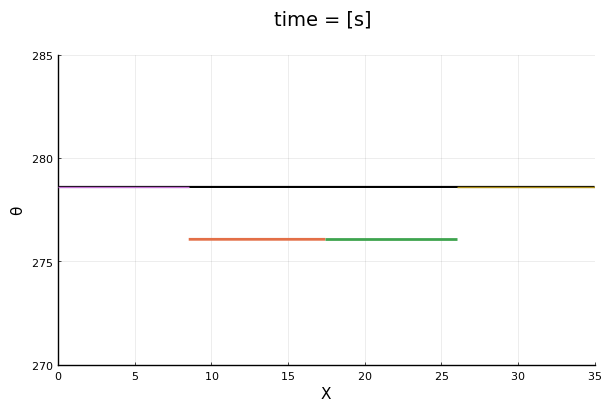

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
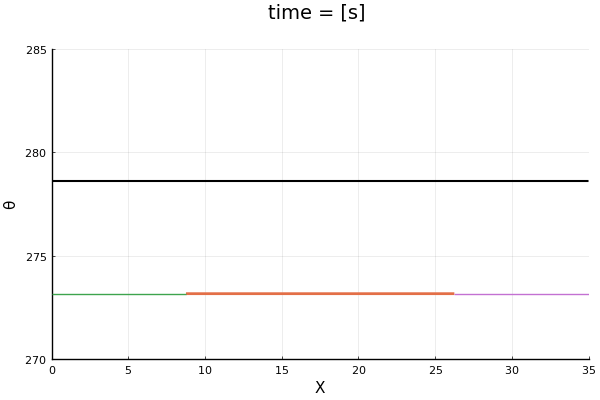

In [400]:
# closed loop plot
@gif for i=1:5:length(sysfinal)
# @gif for i=1:1:80
        
    Xpvapor = getXpvapor(sysfinal[i].liquid.Xp,sysfinal[i].tube.L,sysfinal[i].tube.closedornot)
#     θvapor  = (sysfinal[i].vapor.P).^((γ-1)/γ)
    θvapor  = nondi_PtoT.(sysfinal[i].vapor.P)
    Xp = sysfinal[i].liquid.Xp
    
#     sysfinal[i].wall.θarray = di_T_to_nondi_T(temperature_linesource(plate_hist[i]))
    
    plt = plot([sysfinal[i].wall.Xarray],[sysfinal[i].wall.θarray .* T0], linewidth=1.5,ylim=(270,285),  color = [:black],legend=:none, labels = "θwall", xlabel="X", ylabel="θ", title=(string("time = [s] \n",)),xlim=(0,sysfinal[i].tube.L))
    
    
    j=1
    while j <= length(Xp)
        if Xp[j][end] >= Xp[j][1]
            plot!(plt, [sysfinal[i].liquid.Xarrays[j]],[sysfinal[i].liquid.θarrays[j]] .* T0, linewidth=2, labels = string("θliquid ",j))
            else 
            # find the index at the end
            index = findfirst(x->x <= sysfinal[i].liquid.Xarrays[j][end], sysfinal[i].liquid.Xarrays[j])
            
            plot!(plt, [sysfinal[i].liquid.Xarrays[j][1:index-1]],[sysfinal[i].liquid.θarrays[j][1:index-1]] .* T0, linewidth=2, labels = string("θliquid ",j))
            plot!(plt, [sysfinal[i].liquid.Xarrays[j][index:end]],[sysfinal[i].liquid.θarrays[j][index:end]] .* T0, linewidth=2, labels = string("θliquid ",j))

        end
        
        j += 1
    end

        j=1
    while j <= length(Xpvapor)
        if Xpvapor[j][end] >= Xpvapor[j][1]
            plot!(plt,[Xpvapor[j][1],Xpvapor[j][end]],[θvapor[j]] .* T0, labels = string("θvapor ",j))
            else
            
            plot!(plt,[0.0,Xpvapor[j][end]],[θvapor[j]] .* T0, labels = string("θvapor ",j))
            plot!(plt,[Xpvapor[j][1],L],[θvapor[j]] .* T0, labels = string("θvapor ",j))

        end
        
        j += 1
    end
    
#     j = 1
#     plot!(p,[0.0,Xpvapor[j][end]],[θvapor[j]], labels = string("θvapor ",j))
#     plot!(p,[Xpvapor[j][1],L],[θvapor[j]], labels = string("θvapor ",j))
    
#     j = 2
#     while j  <= length(θvapor) 
    
#         plot!(p,[Xpvapor[j][1],Xpvapor[j][end]],[θvapor[j]], labels = string("θvapor ",j))
        
#         j += 1
#     end

#     vline!( p, [collect(0:2:4)], color=[:blue,:red], width=196, alpha=[0.3,0.3,0.3],labels = "")
    
    end 

In [52]:
# # @gif for i = 1:5:length(sysfinal)
# i=100
#     Htmp = sys_to_Harray(sysfinal[i])
# #         set_linesource_strength!(sys,qtmp)
#     plot(sysfinal[i].wall.Xarray,Htmp)
# # end

In [53]:
# @gif for i=1:100

# # i=100
#     Htmp = sys_to_Harray(sysfinal[i])
#     plot(ohp,fillalpha=0,linecolor=cgrad([:gold, :blue],rev=true),line_z=Htmp,xlabel="x [m]",ylabel="y [m]")
# end

In [54]:
# savefig("OHP.pdf")

In [55]:
integrator_plate.t

0.001

In [56]:
save("plate_OHP.jld2", "plate_hist", plate_hist, "integrator_plate", integrator_plate)

In [57]:
save("tube_OHP.jld2", "tube_hist", tube_hist, "integrator_tube",integrator_tube)

# temperature difference with OHP

### use the same definition of heat conductance in the ASET paper (temperature based on certain locations)

In [58]:
temp_evaporator = temperature(plate_hist[end])[110,48]

temp_condenser_1 = temperature(plate_hist[end])[44,48]
temp_condenser_2 = temperature(plate_hist[end])[end-44+1,48]
temp_condenser  = (temp_condenser_1+temp_condenser_2)/2

tempdiff_ASET = (temp_evaporator - temp_condenser) # K

LoadError: [91mBoundsError: attempt to access 0-element Array{Any,1} at index [0][39m

### use the same definition of heat conductance based on maximum and minimum temperatures)

In [59]:
tempdiff_maximum = maximum(temperature(plate_hist[end]))-minimum(temperature(plate_hist[end])) # K

LoadError: [91mBoundsError: attempt to access 0-element Array{Any,1} at index [0][39m

# thermal conductance with OHP

### use the same definition of heat conductance in the ASET paper (temperature based on certain locations)

In [60]:
heater_power = 40 #watt
cond_ASET =  heater_power /tempdiff_ASET # W/K

LoadError: [91mUndefVarError: tempdiff_ASET not defined[39m

### use the same definition of heat conductance based on maximum and minimum temperatures)

In [61]:
heater_power = 40 #watt
cond_maximum =  heater_power /tempdiff_maximum # W/K

LoadError: [91mUndefVarError: tempdiff_maximum not defined[39m

In [62]:
+
3

3